We have previously calculated the optimal shedding function that minimizes SSE between the observed wastewater data and the model \[I*S\](t).
Now we want to plot a nice and high res figure showing the observed data and model data with MCMC model data points.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

In [2]:
def test_pdf(params):
    a, b, c, = params
    # PDF
    quantile = np.arange(0.0, 1, 1/30)
    B = c * beta.pdf(quantile, a, b) 
    return B

def convolve_I_S(params, I, function):
    if function == 'beta':
        S = test_pdf(params)
    elif function == 'gamma':
#     print('Beta length', len(S))
        S = test_gamma(params)
    W = np.convolve(S, I)
    return W

# shift clinical date time by tau days
def shift_clinical(clin, tau, factor):
    shifted_clinical = clin.copy()
    shifted_clinical['Date'] = shifted_clinical['Date'] - np.timedelta64(int(tau), 'D')
    
    # Apply asymptomatic correction
    shifted_clinical['Corrected_cases'] = shifted_clinical.New_cases * int(factor)

    return shifted_clinical

def evaluate_model(x, ww_data, cases, function):
    #x[0] = a
    #x[1] = b
    #x[2] = c
    # cases['Corrected_cases'] = new cases w/ asymptomatic correction
    # function = beta or gamma
    
    # get real wastewater data:
    W_obs = ww_data.dropna().copy()
    n = len(W_obs)

    # get clinical data
    I_t = cases['Date']
    I = cases['Corrected_cases']

    # set up model params of wastewater data W_model = S o I
    params = (x[0], x[1], x[2])    
    
    # get c * beta(a,b) and convolve with new cases per day
    y_hat = convolve_I_S(params, I, function)
    Y_hat = np.log10(y_hat) # take the log
    
    # transform it into a series and merge with observed data based on date
    Y_hat_series = pd.Series(Y_hat).rename('Log_convolution')
    Y_df = pd.concat([I_t, Y_hat_series], axis=1).dropna()
    Y_merged = Y_df.merge(W_obs, on=['Date'])
    
    # SSE
    SSE = np.sum((Y_merged['log'] - Y_merged['Log_convolution'])**2)
    
    return Y_df, Y_merged, SSE

def fill_dates(data):
    # fill in missing days
    idx = pd.date_range(data.Date.min(), data.Date.max())
    data.index = pd.DatetimeIndex(data.Date)
    data = data.reindex(idx)
    data.Date = data.index
    data = data.reset_index(drop=True)
    
    return data

In [3]:
# plot date formatting
myFmt = mdates.DateFormatter('%b %d')

In [4]:
# import data
ave = pd.read_csv('../data/deer_island/split_paper/2021-06-07_Summary.ABAD_Onestep.6_DNAstandard_nonscaled_average.csv', parse_dates=[0])
AB_alone = pd.read_csv('../data/deer_island/split_paper/2021-06-07_Summary.ABAD_Onestep.6_DNAstandard_AB_alone.csv', parse_dates=[2])
AD_alone = pd.read_csv('../data/deer_island/split_paper/2021-06-07_Summary.ABAD_Onestep.6_DNAstandard_AD_alone.csv', parse_dates=[2])

# fill in missing dates
ave = fill_dates(ave)
AB_alone = fill_dates(AB_alone)
AD_alone = fill_dates(AD_alone)

# Read in clinical case counts for Deer Island counties
clinical = pd.read_csv('../data/deer_island/20200520_DI_counties_Middlesex_clinical_counts_FQW.csv',
                      parse_dates=[0])

# change to logs
clinical['log_new_cases'] = np.log10(clinical['New_cases'])
clinical.loc[~np.isfinite(clinical.log_new_cases), 'log_new_cases'] = 0.0

AB_alone['log'] = np.log10(AB_alone['Adjusted.Copyperml'])
AD_alone['log'] = np.log10(AD_alone['Adjusted.Copyperml'])
ave['log'] = np.log10(ave['Adjusted.Copyperml'])

C:\Users\harum\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


## nonscaled average, tau=4

In [6]:
# read in MCMC params
accepted_df = pd.read_csv('../data/deer_island/stoten_revision_data/beta/2021-08-04_MCMC_accepted_params_ave.csv')
accepted_df.head()

# MLE params
best_abc = (10.736122057797292, 197.61942367641294, 0.03107246888001779)
best_tau = 4

# get random100
random_100 = accepted_df.sample(n=100)

C:\Users\harum\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log10


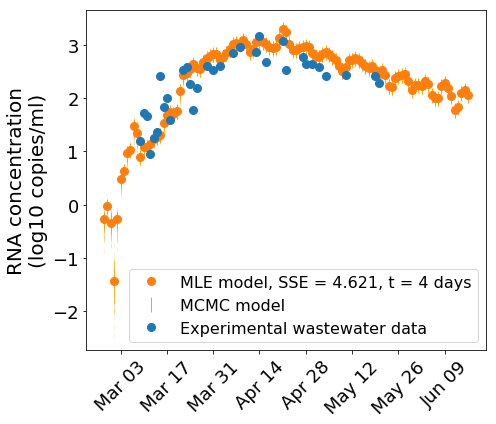

In [7]:
# iterate through 100 random MCMC traces and plot

# shift clinical data by 4 days
shifted = shift_clinical(clinical, best_tau, factor=1)

# evaluate model for MLE
Wm_df, Wm_merged, score = evaluate_model(best_abc, ave, shifted, 'beta')

fig, ax = plt.subplots(figsize=(7,6))

for _, row in random_100.iterrows():
    test_params = row.values
    Wm_df, _, _ = evaluate_model(test_params, ave, shifted, 'beta')
    plt.plot_date(Wm_df.loc[Wm_df.Date < '2020-06-03', 'Date'], Wm_df.loc[Wm_df.Date < '2020-06-03','Log_convolution'], marker="|", markersize=4, color="orange", alpha=0.2, label='_nolegend_')

MLE_label = 'MLE model, SSE = ' + str(round(score,3)) + ', t = 4 days'
plt.plot_date(Wm_df['Date'], Wm_df['Log_convolution'], markersize=8, color="tab:orange", label=MLE_label, zorder=102)
plt.plot_date(Wm_df['Date'], Wm_df['Log_convolution'], marker="|", markersize=15, color="orange", label='MCMC model', zorder=101)
plt.plot_date(Wm_merged['Date'], Wm_merged['log'], markersize=8, color="tab:blue", label='Experimental wastewater data', zorder=103)

plt.legend(fontsize=16)
plt.xticks(rotation=45, fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('RNA concentration\n(log10 copies/ml)', fontsize=20)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(myFmt)
# textbox = 'SSE: ' + str(round(score,3)) + '\nTime lag: ' + str(best_tau) + ' days'
# plt.text('2020-03-31', -0.5, textbox, fontsize=18)
plt.tight_layout()

plt.savefig('../figures/stoten_revision/2021-08-04_Fig1F_beta_convolution_tau4_nonscaled_ave.pdf', dpi=300, format='pdf')

## AD alone, tau=4

C:\Users\harum\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log10


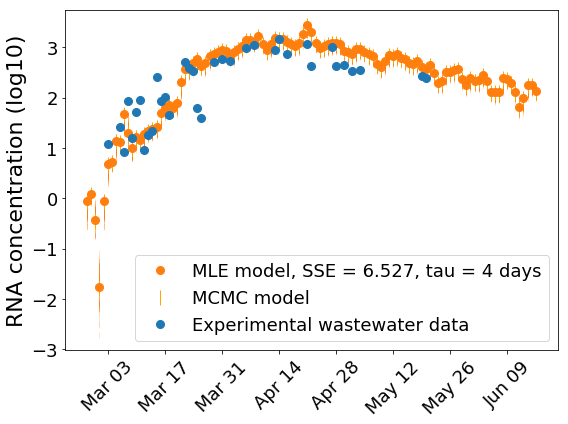

In [8]:
# read in MCMC params
accepted_df = pd.read_csv('../data/deer_island/stoten_revision_data/beta/2021-08-04_MCMC_accepted_params_AD_alone_tau4.csv')
accepted_df.head()

# MLE params
best_abc = (10.379535961073248, 197.00652708376086, 0.03413144574242055)
best_tau = 4

# get random100
random_100 = accepted_df.sample(n=100)

# iterate through 100 random MCMC traces and plot

# shift clinical data by 4 days
shifted = shift_clinical(clinical, best_tau, factor=1)

# evaluate model for MLE
Wm_df, Wm_merged, score = evaluate_model(best_abc, AD_alone, shifted, 'beta')

fig, ax = plt.subplots(figsize=(8,6))

for _, row in random_100.iterrows():
    test_params = row.values
    Wm_df, _, _ = evaluate_model(test_params, AD_alone, shifted, 'beta')
    plt.plot_date(Wm_df['Date'], Wm_df['Log_convolution'], marker="|", color="tab:orange", alpha=0.2, label='_nolegend_')

MLE_label = 'MLE model, SSE = ' + str(round(score,3)) + ', tau = 4 days'
plt.plot_date(Wm_df['Date'], Wm_df['Log_convolution'], markersize=8, color="tab:orange", label=MLE_label, zorder=102)
plt.plot_date(Wm_df['Date'], Wm_df['Log_convolution'], marker="|", markersize=15, color="orange", label='MCMC model', zorder=101)
plt.plot_date(Wm_merged['Date'], Wm_merged['log'], markersize=8, color="tab:blue", label='Experimental wastewater data', zorder=103)

plt.legend(fontsize=18)
plt.xticks(rotation=45, fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('RNA concentration (log10)', fontsize=22)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(myFmt)
plt.tight_layout()

plt.savefig('../figures/stoten_revision/2021-08-04_FigS6A_beta_convolution_tau4_AD_alone.pdf', dpi=300, format='pdf')

C:\Users\harum\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log10


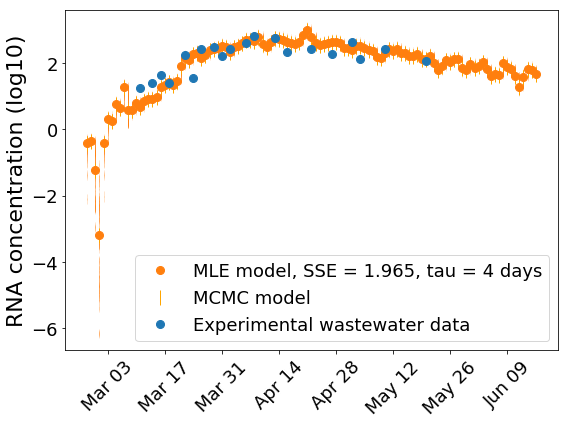

In [9]:
# read in MCMC params
accepted_df = pd.read_csv('../data/deer_island/stoten_revision_data/beta/2021-08-04_MCMC_accepted_params_AB_alone.csv')

accepted_df.head()

# MLE params
best_abc = (9.757025099928327, 200.89016414287826, 0.014016077280861138)
best_tau = 4

# get random100
random_100 = accepted_df.sample(n=100)

# iterate through 100 random MCMC traces and plot

# shift clinical data by 4 days
shifted = shift_clinical(clinical, best_tau, factor=1.0)

# evaluate model for MLE
Wm_df, Wm_merged, score = evaluate_model(best_abc, AB_alone, shifted, 'beta')

fig, ax = plt.subplots(figsize=(8,6))

for _, row in random_100.iterrows():
    test_params = row.values
    Wm_df, _, _ = evaluate_model(test_params, AB_alone, shifted, 'beta')
    plt.plot_date(Wm_df['Date'], Wm_df['Log_convolution'], marker="|", color="tab:orange", alpha=0.2, label='_nolegend_')

MLE_label = 'MLE model, SSE = ' + str(round(score,3)) + ', tau = 4 days'
plt.plot_date(Wm_df['Date'], Wm_df['Log_convolution'], markersize=8, color="tab:orange", label=MLE_label, zorder=102)
plt.plot_date(Wm_df['Date'], Wm_df['Log_convolution'], marker="|", markersize=15, color="orange", label='MCMC model', zorder=101)
plt.plot_date(Wm_merged['Date'], Wm_merged['log'], markersize=8, color="tab:blue", label='Experimental wastewater data', zorder=103)

plt.legend(fontsize=18)
plt.xticks(rotation=45, fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('RNA concentration (log10)', fontsize=22)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(myFmt)

plt.tight_layout()

plt.savefig('../figures/stoten_revision/2021-08-04_FigS7A_beta_convolution_tau4_AB_alone.pdf', dpi=300, format='pdf')